In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os

if 'notebooks' in os.getcwd():
    os.chdir("..")

print(os.getcwd())

/Users/jh/dev/python/foundation


In [8]:
from src.main.core import Value, Graph
from src.main.visualisation import draw_dot

In [5]:
a = Value(data=2.0, label="a"); a.grad = 6.0
b = Value(data=-3.0, label="b"); b.grad = -4.0
c = Value(data=10.0, label="c"); c.grad = -2.0

d = a * b; d.label = "d"; d.grad = -2.0
e = d + c; e.label = "e"; e.grad = -2.0
f = Value(data=-2.0, label="f"); f.grad = 4.0
L = e * f; L.label = "L"
L.grad = 1.0

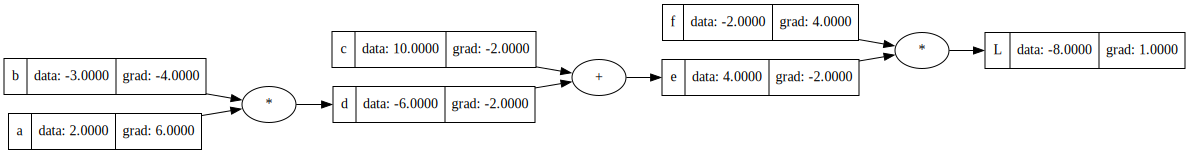

In [6]:
draw_dot(L)

## Derivatives by hand:

d(L)/dL = 1 * L^0 = 1.0

L = e * f = e^1 * f = e * f^1  

d(L)/de = 1 * e^0 * f = f = -2.0  
d(L)/df = e * 1 * f^0 = e = 4.0  

## Backpropagation > Chain rule

e = d + c

#### local derivates:  
d(e)/dd = 1.0  
d(e)/dc = 1.0  

#### chain rule:
d(L)/dd = d(L)/de * d(e)/dd = -2.0 * 1.0 = -2.0  
d(L)/dc = d(L)/de * d(e)/dc = -2.0 * 1.0 = -2.0  


d = a * b

#### local derivates:  
d(d)/da = b = -3.0  
d(d)/db = a = 2.0

#### chain rule:
d(L)/da = d(L)/de * d(e)/dd * d(d)/da = -2.0 * 1.0 * -3.0 = 6.0  
d(L)/db = d(L)/de * d(e)/dd * d(d)/db = -2.0 * 1.0 * 2.0 = -4.0  

## With other words

a.grad = b.data * d.grad  
b.grad = a.data * d.grad  
c.grad = e.grad  
d.grad = e.grad  
e.grad = L.grad * f.data  
f.grad = L.grad * e.data  
L.grad = 1.0  


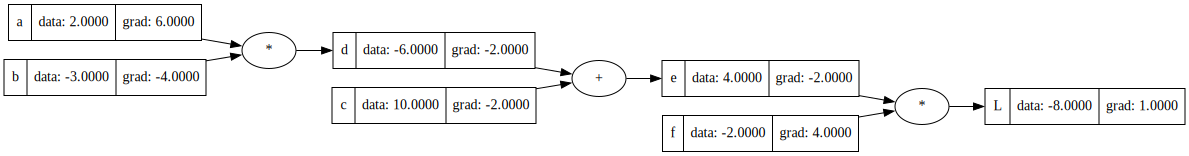

In [50]:
draw_dot(L)

In [51]:
# forward pass

step_size = 0.01

a.data += step_size * a.grad
b.data += step_size * b.grad
c.data += step_size * c.grad
f.data += step_size * f.grad

d = a * b
e = c + d
L = e * f

L.data

-7.286496

## Neuron

In [52]:
# input values
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
bias = Value(6.8813735870195432, label="b")

# weighted inputs
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# neuron
neuron = x1w1x2w2 + bias; neuron.label = "n"

#output
output = neuron.tanh(); output.label = "o"

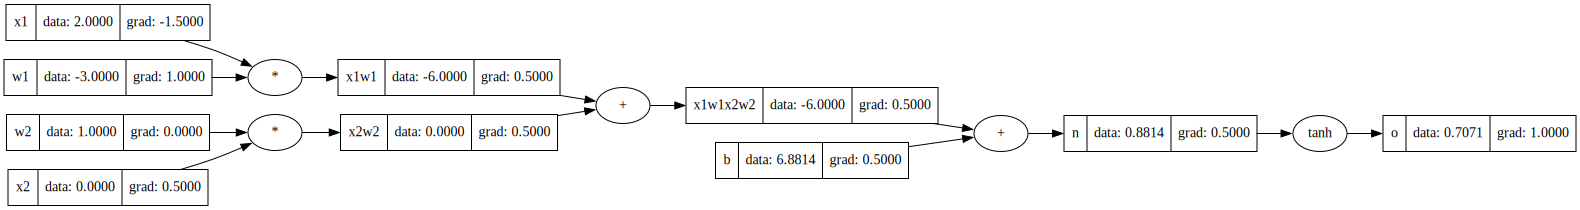

In [55]:
draw_dot(output)

### Automated backward propagation

In [54]:
output.backward()

### Semi automated backward progapagation

In [ ]:
output.grad = 1.0

In [ ]:
output._backward()

In [ ]:
neuron._backward()

In [ ]:
bias._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()

In [ ]:
x1w1._backward()

### Manuall backward propogation

In [ ]:
output.grad = 1.0

neuron.grad = 1 - math.tanh(neuron.data)**2 * output.grad # 0.5 => chain rule + derivative of tanh(x) according to wikipedia

bias.grad = neuron.grad # 0.5
x1w1x2w2.grad = neuron.grad # 0.5

x1w1.grad = x1w1x2w2.grad # 0.5
x2w2.grad = x1w1x2w2.grad # 0.5

x1.grad = w1.data * x1w1.grad # -1.5
w1.grad = x1.data * x1w1.grad # 1.0

x2.grad = w2.data * x2w2.grad # 0.5
w2.grad = x2.data * x2w2.grad # 0.0

## Derivatives

o = tanh(n)  
d(o)/dn = 1 - o^2 = 0.5 # wikipedia  


## Redesign tanh

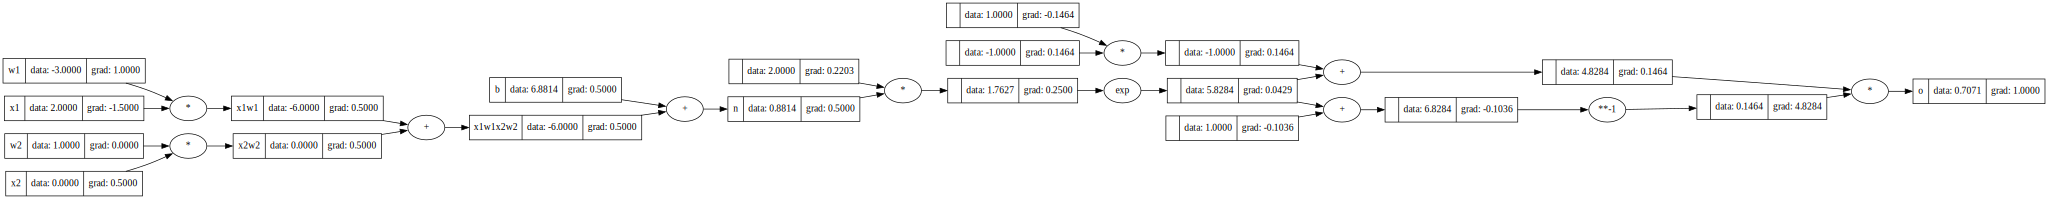

In [9]:
# input values
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

# bias
bias = Value(6.8813735870195432, label="b")

# weighted inputs
x1w1 = x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2; x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

# neuron
neuron = x1w1x2w2 + bias; neuron.label = "n"

#output
# output = neuron.tanh()
exp = (2 * neuron).exp()
output = (exp - 1)/(exp + 1)

output.label = "o"
output.backward()
draw_dot(output)